In [1]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import wandb


2023-03-14 13:20:08.376439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 13:20:08.629979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 13:20:08.630002: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 13:20:09.510164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Fashion Mnist Dataset

In [2]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()

### Question 1

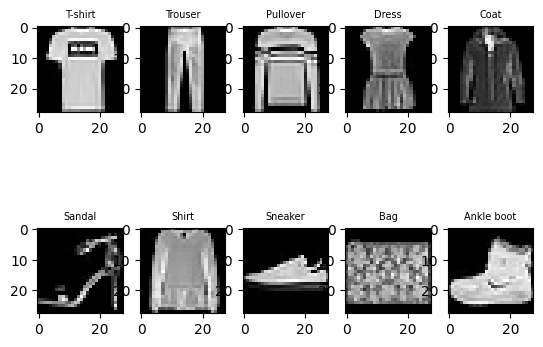

In [3]:
num_classes = len(np.unique(Y))
# for i in range(num_classes):
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["T-shirt", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1], cmap=plt.get_cmap('gray'))
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [4]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.1, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T
X_test = X_test.T


Size of Training DataSet = 54000
Size of Validation DataSet = 6000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Question 2

In [5]:
# output_layer_nodes = num_classes
# input_layer_nodes = num_features

In [6]:
# from scipy.special import softmax
def sigmoid(x):
    return 1. /(1. + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-(np.tanh(x)**2)

def der_relu(x):
    return (x>0)*1

def softmax(x):
    return (np.exp(x)/np.sum(np.exp(x),axis = 0))

def der_softmax(x):
    return softmax(x) * (1-softmax(x))

### Hidden Layer


In [7]:
class hidden_layer:
    '''
        num_neurons : number of neurons in the layer
        dim_in_layer : inlayer dimensions
        dim_out_layer : outLayer dimensions
        W : Weights
        b : Biases
        grad_W : gradient of weights
        grad_B : gradient of biases
    '''
    def __init__(self,num_neurons,dim_in_layer,dim_out_layer = -1):
        self.weight_initializers = {"random": self.random_initialization, "Xavier": self.xavier_intialization}
        self.num_neurons = num_neurons
        self.dim_in_layer = dim_in_layer
        self.dim_out_layer = dim_out_layer
        
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)

    def xavier_intialization(self, in_layer, out_layer):
        # return np.random.normal(0, np.sqrt(2 / (in_layer + out_layer)), size=(in_layer, out_layer))
        return np.random.randn(in_layer, out_layer)* np.sqrt(2 / (in_layer + out_layer))
    
    def initialize_layer(self,initializer):
        N = self.num_neurons
        self.W = self.weight_initializers[initializer](in_layer =N ,out_layer = self.dim_in_layer)
        self.b = np.zeros(shape=(N,1))
        
        self.grad_W = self.weight_initializers[initializer](in_layer = N,out_layer = self.dim_in_layer)
        self.grad_b = np.zeros(shape=(N,1))
        
        self.u_mgd_W = np.zeros(shape=(N,self.dim_in_layer))
        self.u_mgd_b = np.zeros(shape=(N,1))
        
        self.m_W = np.zeros(shape=(N,self.dim_in_layer))
        self.m_b = np.zeros(shape=(N,1))

### Parameter class

### Feedforward Neural Network

In [37]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nestrov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all hidden layer 
        weight_Decay : 
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        beta : momentum
        beta1 : adam
        beta2 : adam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                 weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 output_activation = softmax,
                 der_output_activation = der_softmax,
                 beta=0.9,
                 epsilon=1e-6,
                 beta1=0.9,
                 beta2=0.9):
        self.weight_initializer = weight_initializer
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nestrov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.der_activation = self.der_activation_functions[activation]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.output_activation = output_activation
        self.der_output_activation = der_output_activation
        self.weight_decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # return self
    
    def sgd(self,X,Y):
        # self.ForwardPropagation(X)
        # self.BackPropagation(self.output_layer.h,Y,X)
        # L = self.hidden_layers
        # eta = self.learning_rate
        # for i in range(self.num_hidden_layers):
        #     L[i].W = L[i].W - eta*L[i].grad_W
        #     L[i].b = L[i].b - eta*L[i].grad_b
        # self.output_layer.W = self.output_layer.W - eta*self.output_layer.grad_W
        # self.output_layer.b = self.output_layer.b - eta*self.output_layer.grad_b
        eta = self.learning_rate
        W,b = self.getWB() # W,b are lists
        N = len(W)
        A,H = self.ForwardPropagation_new(X,W,b)
        grad_w,grad_b,W = self.BackPropagation_new(H[N-1],Y,X,W,b,A,H)
        for i in range(N):
            W[i] = W[i] - eta*grad_w[i]
            b[i] = b[i] - eta*grad_b[i]
        self.putWB(W,b)
        
    def nestrov(self,X,Y):
        L = self.hidden_layers
        beta  = self.beta
        eta = self.learning_rate
        
        for i in range(self.num_hidden_layers):
            L[i].lookahead_W = L[i].W - beta*L[i].u_mgd_W
            L[i].lookahead_b = L[i].b - beta*L[i].u_mgd_b
        self.output_layer.lookahead_W = self.output_layer.W - beta*self.output_layer.u_mgd_W
        self.output_layer.lookahead_b = self.output_layer.b - beta*self.output_layer.u_mgd_b
        
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = beta*L[i].u_mgd_W + L[i].grad_W
            L[i].u_mgd_b = beta*L[i].u_mgd_b + L[i].grad_b
            L[i].W = L[i].W - eta*L[i].u_mgd_W
            L[i].b = L[i].b - eta*L[i].u_mgd_b
        self.output_layer.u_mgd_W = beta*self.output_layer.u_mgd_W + self.output_layer.grad_W
        self.output_layer.u_mgd_b = beta*self.output_layer.u_mgd_b + self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - eta*self.output_layer.u_mgd_W
        self.output_layer.b = self.output_layer.b - eta*self.output_layer.u_mgd_b
        # pass
    
    def momentum(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta = self.beta
        eta = self.learning_rate
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = beta*L[i].u_mgd_W + L[i].grad_W
            L[i].u_mgd_b = beta*L[i].u_mgd_b + L[i].grad_b
            L[i].W = L[i].W - eta*L[i].u_mgd_W
            L[i].b = L[i].b - eta*L[i].u_mgd_b
        self.output_layer.u_mgd_W = beta*self.output_layer.u_mgd_W + self.output_layer.grad_W
        self.output_layer.u_mgd_b = beta*self.output_layer.u_mgd_b + self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - eta*self.output_layer.u_mgd_W
        self.output_layer.b = self.output_layer.b - eta*self.output_layer.u_mgd_b
        # pass
    
    def rmsprop(self,X,Y):
        # self.print_all()
        
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        # print(self.output_layer.h)
        L = self.hidden_layers
        beta = self.beta
        eta = self.learning_rate
        epsilon = self.epsilon
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = beta*L[i].u_mgd_W + (1-beta)*L[i].grad_W
            L[i].u_mgd_b = beta*L[i].u_mgd_b + (1-beta)*L[i].grad_b
            L[i].W = L[i].W - (eta*L[i].grad_W/(np.sqrt(L[i].u_mgd_W)+epsilon))
            L[i].b = L[i].b - (eta*L[i].grad_b/(np.sqrt(L[i].u_mgd_b)+epsilon))
        self.output_layer.u_mgd_W = beta*self.output_layer.u_mgd_W + (1-beta)*self.output_layer.grad_W
        self.output_layer.u_mgd_b = beta*self.output_layer.u_mgd_b + (1-beta)*self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - (eta*self.output_layer.grad_W/(np.sqrt(self.output_layer.u_mgd_W)+epsilon))
        self.output_layer.b = self.output_layer.b - (eta*self.output_layer.grad_b/(np.sqrt(self.output_layer.u_mgd_b)+epsilon))
        
        # self.print_all()
        # pass
    
    def adam(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        eta = self.learning_rate
        epsilon = self.epsilon
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
            L[i].b = L[i].b - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (eta*m_hat_W/(np.sqrt(u_hat_W)+epsilon))
        output.b = output.b - (eta*m_hat_b/(np.sqrt(u_hat_b)+epsilon))
            
        # pass
    def nadam(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y,X)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        eta = self.learning_rate
        epsilon = self.epsilon
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            #hereeeeeeeee
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            #hereeeeeeeee
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (eta/(np.sqrt(u_hat_W+epsilon)))*(beta1*m_hat_W+(1-beta1)*L[i].grad_W/(1-beta1**(i+1)))
            L[i].b = L[i].b - (eta/(np.sqrt(u_hat_b+epsilon)))*(beta1*m_hat_b+(1-beta1)*L[i].grad_b/(1-beta1**(i+1)))
            # (eta/np.sqrt(v_w_hat+eps))* (beta1*m_w_hat+(1-beta1)*dw/(1-beta1**(i+1)))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (eta/(np.sqrt(u_hat_W+epsilon)))*(beta1*m_hat_W+(1-beta1)*output.grad_W/(1-beta1**(i+1)))
        output.b = output.b - (eta/(np.sqrt(u_hat_b+epsilon)))*(beta1*m_hat_b+(1-beta1)*output.grad_b/(1-beta1**(i+1)))
        # pass
    
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])
    
    def initialize_hidden_layers(self):
        L = []
        in_layer, out_layer = num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
                
            L.append(hidden_layer(self.hidden_layer_dims[i],in_layer,out_layer))
            
        self.hidden_layers = L
        self.output_layer = hidden_layer(self.output_layer_dim,self.hidden_layer_dims[self.num_hidden_layers-1],-1)
        
    def sanitize_Y(self):
            
        temp = np.zeros((num_classes,self.Y_train.shape[0]))
        for i in range(self.Y_train.shape[0]) :
            temp[int(self.Y_train[i])][i] = 1
        self.Y_train = temp
        # self.Y_train = np.array(temp).T
        
        temp = np.zeros((num_classes,self.Yv.shape[0]))
        for i in range(self.Yv.shape[0]) :
            temp[int(self.Yv[i])][i] = 1
        self.Yv = temp
        
        # temp = []
        # for i in self.Yv :
        #     temp1 = np.zeros(num_classes)
        #     temp1[i]=1
        #     temp.append(temp1)
        # self.Yv = np.array(temp).T
        # print(Yv[0])
        # pass
    
    def initialize_NeuralNet(self):
        for i in range(self.num_hidden_layers):
            self.hidden_layers[i].initialize_layer(self.weight_initializer)
        self.output_layer.initialize_layer(self.weight_initializer)
        self.sanitize_Y()
        # pass
    
    def add_hidden(self,num_neurons):
        self.hidden_layer_dims.append(num_neurons)
        self.num_hidden_layers += 1
        # pass
    
    def getWB(self):
        weights = [x.W.copy() for x in self.hidden_layers]
        biases =  [x.b.copy() for x in self.hidden_layers]
        weights.append((self.output_layer.W).copy())
        biases.append((self.output_layer.b).copy())
        return weights,biases
    
    def putWB(self,W,b):
        for i in range(len(W)-1):
            self.hidden_layers[i].W = W[i]
            self.hidden_layers[i].b = b[i]
        self.output_layer.W = W[len(W)-1]
        self.output_layer.b = b[len(W)-1]
            
    
    def ForwardPropagation_new(self,X,W,b):
        A = [None]*len(W)
        H = [None]*len(b)
        # print(len(W))
        for i in range(len(W)):
            if i == 0:
                A[i] = b[i] + W[i]@X
            else:
                A[i] = b[i] + W[i]@H[i-1]
            if i == len(W) - 1:
                H[i] = self.output_activation(A[i])
            else:
                H[i] = self.activation(A[i])
        return A,H
    
    
    def ForwardPropagation(self,X):
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            if i==0:
                L[i].a = (L[i].b + np.matmul(L[i].W,X))
            else:
                L[i].a = (L[i].b + np.matmul(L[i].W,L[i-1].h))
            L[i].h = self.activation(L[i].a)
        self.output_layer.a = (self.output_layer.b + np.matmul(self.output_layer.W,L[self.num_hidden_layers-1].h))
        # print("Output before activagtion", self.output_layer.a)
        # print(self.output_activation)
        self.output_layer.h = self.output_activation(self.output_layer.a)
        # print("Loss", self.Cross_Entropy_Loss(self.output_layert))
        # print("OUtput layer", self.output_layer.h)
        # pass
    
    def BackPropagation_new(self,Y_hat,Y,X,W,b,A,H):
        grad_a = [None]*len(A)
        grad_h = [None]*len(H)
        grad_w = [None]*len(W)
        grad_b = [None]*len(b)
        N = len(W)
        grad_a[N-1] = Y_hat - Y
        
        for i in range(N-1,-1,-1):
            if i == 0:
                grad_w[i] = grad_a[i]@X.T
            else:
                grad_w[i] = grad_a[i]@H[i-1].T
            grad_b[i] = np.sum(grad_a[i],axis=1,keepdims=True)
            if i>0 :
                grad_h[i-1] = W[i].T@grad_a[i]
                grad_a[i-1] = grad_h[i-1]*self.der_activation(A[i-1])
                
        for i in range(N):
            W[i] += self.weight_decay*W[i]
            
        return grad_w,grad_b,W
    
    def BackPropagation(self,y_hat,y,X):
        L = self.hidden_layers
        N = self.num_hidden_layers
        out_layer = self.output_layer
        
        out_layer.grad_a = y_hat - y
        # out_layer.grad_W = (np.matmul(out_layer.grad_a,L[N-1].h.T)+self.weight_decay*out_layer.W)/self.batch_size
        out_layer.grad_W = np.matmul(out_layer.grad_a,L[N-1].h.T)
        # out_layer.grad_b = out_layer.grad_a
        out_layer.grad_b = np.sum(out_layer.grad_a,axis=1,keepdims=True)#/self.batch_size
        # print("b dims ",out_layer.grad_b.shape)
        L[N-1].grad_h = np.matmul(out_layer.W.T,out_layer.grad_a)
        L[N-1].grad_a = L[N-1].grad_h * self.der_activation(L[N-1].a)
        
        for i in range(N-1,-1,-1):
            if(i==0):
                # L[i].grad_W = (np.matmul(L[i].grad_a,X.T)+self.weight_decay*L[i].W)/self.batch_size
                L[i].grad_W = np.matmul(L[i].grad_a,X.T)
            else:
                # L[i].grad_W = (np.matmul(L[i].grad_a,L[i-1].h.T)+self.weight_decay*L[i].W)/self.batch_size
                L[i].grad_W = np.matmul(L[i].grad_a,L[i-1].h.T)
            L[i].grad_b = np.sum(L[i].grad_a,axis=1,keepdims=True)#/self.batch_size
            # L[i].grad_b = L[i].grad_a
            if i>0:
                L[i-1].grad_h = np.matmul(L[i].W.T,L[i].grad_a)
                L[i-1].grad_a = L[i-1].grad_h * self.der_activation(L[i-1].a)
        
        # out_layer.W += self.weight_decay*out_layer.W
        # for i in range(N):
        #     L[i].W += self.weight_decay*L[i].W
        # pass
        
    
    def fit_NeuralNet(self):
        self.initialize_hidden_layers()
        self.initialize_NeuralNet()
        for curr_epoch in range(self.num_epochs):
            print(curr_epoch)
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(self.X_train.shape[1]-i,self.batch_size)
                # self.ForwardPropagation(self.X_train[:,i:i+curr_batch])
                # self.BackPropagation(self.output_layer.h,self.Y_train[:,i:i+curr_batch],self.X_train[:,i:i+curr_batch])
                self.optimizer(self.X_train[:,i:i+curr_batch],self.Y_train[:,i:i+curr_batch])
                
                
            # Y_pred = self.predict_NeuralNet(X_train)
            # print("Loss ", self.Cross_Entropy_Loss(Y_pred, Y_train))
        # pass
    
    def predict_NeuralNet(self,X):
        self.ForwardPropagation(X)
        # for i in range(10):
        #     print(self.output_layer.h[0][i], sep=" ")
        Y_pred = np.argmax(self.output_layer.h,axis=0)
        return Y_pred
        
    def print_all(self):
        # print("weight_initializer = ",self.weight_initializer)
        # print("activation_functions = ",self.activation_functions)
        # print("optimizer_functions = ",self.optimizer_functions)
        # print("weight_initializers = ",self.weight_initializers)
        # print("activation = ",self.activation)
        # print("optimizer = ",self.optimizer)
        # print("learning_rate = ",self.learning_rate)
        # print("batch_size = ",self.batch_size)
        # print("num_epochs = ",self.num_epochs)
        # print("num_hidden_layers = ",self.num_hidden_layers)
        # print("output_layer_dim = ",self.output_layer_dim)
        # print("hidden_layer_dims = ",self.hidden_layer_dims)
        # print("num_features = ",self.num_features)
        # print("weight_Decay = ",self.weight_Decay)
        # print("X_train = ",self.X_train)
        # print("Y_train = ",self.Y_train)
        # print("Xv = ",self.Xv)
        # print("Yv = ",self.Yv)
        # print(self.output_layer.h)
        # print(self.num_hidden_layers)
        
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            
            # print(i)
            # print(i," ",self.hidden_layers[i].dim_in_layer,self.hidden_layers[i].num_neurons,self.hidden_layers[i].dim_out_layer,self.hidden_layers[i].W.shape,self.hidden_layers[i].b.shape)
            # print(self.hidden_layers[i].W)
            # print(self.hidden_layers[i].b)
            # print(L[i].W.shape,L[i].grad_W.shape,L[i].u_mgd_W.shape,L[i].m_W.shape)
            # print(L[i].grad_a.shape)
            print(L[i].W)
            print(L[i].b)
            print(L[i].grad_W)
            print(L[i].grad_b)
        print(self.output_layer.W)
        print(self.output_layer.b)
        print(self.output_layer.grad_W)
        print(self.output_layer.grad_b)
        
        print()
        # print(self.output_layer.W.shape,self.output_layer.grad_W.shape)
        # print(self.output_layer.grad_a.shape)
        # print("output-layer")
        # print(self.output_layer.W.shape)
        # print("o  ",self.output_layer.num_neurons,self.output_layer.dim_in_layer,self.output_layer.dim_out_layer)
        # pass
    

In [26]:
# print(X_train.shape)
ty = np.array([1,2,3])
re = np.zeros(3)
re[0] = ty
print(re)

ValueError: setting an array element with a sequence.

In [38]:
NUM_FEATURES = X_train.shape[0]
WEIGHT_INITIALIZER = "random"
NUM_HIDDEN_LAYERS = 3
HIDDEN_LAYER_DIMS = (128+np.arange(NUM_HIDDEN_LAYERS)).astype(int)
# HIDDEN_LAYER_DIMS = (128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int)
OPTIMIZER = "sgd"
LEARNING_RATE = 0.001
ACTIVATION = "sigmoid"
OUTPUT_LAYER_DIM = num_classes
BATCH_SIZE = 128
EPOCHS = 1
WEIGHT_DECAY = 0

N = NeuralNet(num_features = NUM_FEATURES,
                weight_initializer = WEIGHT_INITIALIZER,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                hidden_layer_dims = HIDDEN_LAYER_DIMS,
                optimizer = OPTIMIZER,
                learning_rate = LEARNING_RATE,
                activation = ACTIVATION,
                X_train = X_train,
                Y_train = Y_train,
                Xv = Xv,
                Yv = Yv,
                weight_decay=WEIGHT_DECAY,
                output_layer_dim = OUTPUT_LAYER_DIM,
                batch_size = BATCH_SIZE,
                num_epochs = EPOCHS)

# N.initialize_hidden_layers()
# N.initialize_NeuralNet()
# N.ForwardPropagation(N.X_train[:,0:500])
# print(N.Y_train[:,0:500].shape)
# print(N.output_layer.h.shape)
# N.BackPropagation(N.output_layer.h,N.Y_train[:,0:500],N.X_train[:,0:500])
# N.print_all()
N.fit_NeuralNet()
N.print_all()
# print(X_train.shape)
# for i in range(X_train.shape[0]):
#     N.ForwardPropagation(X_train[i])




0


/tmp/ipykernel_4262/755351156.py:3: RuntimeWarning: overflow encountered in exp
  return 1. /(1. + np.exp(-x))


[[ 2.26272611e-03  8.71207906e-01  2.33430945e+00 ... -2.75422589e-01
  -1.01124208e+00  4.57771220e-01]
 [ 2.78425651e+00  1.48106403e-01  9.25187542e-01 ...  6.91842700e-01
   9.67828608e-01  1.35030080e-01]
 [ 5.54253350e-01  1.07022227e+00  1.35703374e+00 ...  1.63997127e+00
  -7.82557817e-01 -1.28631346e+00]
 ...
 [ 4.37681624e-01 -1.73838913e-01 -4.29534582e-01 ... -5.90345816e-01
   6.33414762e-01  3.29527445e-01]
 [ 2.07025063e+00 -6.95266238e-01  5.11203451e-02 ... -9.93284092e-01
  -8.12844365e-01  1.46376682e+00]
 [ 6.55522133e-02  8.28898714e-02 -7.73725976e-01 ...  1.32200472e+00
  -9.97570774e-01 -1.84312039e-01]]
[[ 6.93708747e-04]
 [-4.65906995e-04]
 [ 6.87403632e-04]
 [-6.49268647e-04]
 [ 3.98727293e-04]
 [-2.39848349e-04]
 [ 2.18384804e-04]
 [-3.07761908e-04]
 [ 5.02586538e-04]
 [-6.41869189e-04]
 [-2.51317235e-04]
 [ 7.45393000e-05]
 [ 4.08850768e-04]
 [-6.96924155e-04]
 [-7.60933987e-04]
 [ 3.03780067e-04]
 [ 6.82253990e-04]
 [ 7.88153274e-05]
 [-2.48497120e-04]
 [-

In [11]:
# print(N.activation(0))
print(N.X_train.shape)
print(N.Y_train.shape)
# for i in range(0,N.X_train.shape[1],N.batch_size):
#     curr_batch = min(N.X_train.shape[1]-i,N.batch_size)
#     print(i,i+curr_batch)
# ty = np.arange(10)
# print(ty[0:5])

(784, 54000)
(10, 54000)


In [39]:

Y_pred_train = N.predict_NeuralNet(N.X_train)
# print(accuracy_score(y_pred=Y_pred_train,y_true=Y_train))
# for i in Y_pred_train:
#     print(i)
# for i in Y_pred_train:
#     print(i)
# print(Y_pred_train)
# print(accuracy_score(y_pred=Y_pred_train,y_true=Y_train))

/tmp/ipykernel_4262/755351156.py:3: RuntimeWarning: overflow encountered in exp
  return 1. /(1. + np.exp(-x))


In [40]:
print(accuracy_score(y_pred=Y_pred_train,y_true=Y_train))

0.6001296296296297


In [12]:
# a=np.array([[1,2,3],[1,2,3]])
b = np.zeros(100)
a = np.array([])
a=np.concatenate((a,b))
print(np.concatenate((a,b)).shape)

(200,)


In [13]:
# a = np.zeros(shape=(4,3)) + 3
print(Y_train.shape)
# b = np.zeros(shape=(3,10)) + 4

# c = np.zeros(4).reshape(4,1) + 1
# # print(c)
# x = np.matmul(a,b) + c
# print(x)
# print(sigmoid(a))
# print(b)
# print(a*b)
# l = []
# for i in range(0,50,10):
#     l.append(min(50-i,10))
# print(l)
# ty =np.zeros((2,))
# dy =np.zeros((2,))
# print(ty.shape)
# ty.reshape(1,2)
# print(np.matmul(np.transpose(ty),dy))
# t = Y_train[0:100].shape
# print(t)
# a = np.zeros((10,10))
# b = np.zeros((5,3))+12
# b.resize((5,5))
# print(b)
# print(X_test.shape)
print(np.flip(np.arange(10)))
# a[:],b = b,a
# print((128+np.zeros(NUM_HIDDEN_LAYERS)).astype(int))
# print(b[0:2])
# print(np.flip(b))
# x = jk.reshape((jk.shape[0],10))
# print(jk.reshape((10,1)))
# print(X_train.shape)

(48000,)
[9 8 7 6 5 4 3 2 1 0]
